Passos ->
- Entndimento do problema
    - Objetivo: prever Beats Per Minute
    - Métrica de Avaliação: RMSE
    - Tipo de Modelo: Regrssão
- EDA
    - Distribuição do tagert
        - Validação de outliers e distribuições assimétricas
    - Correlação
        - Correlação com o target e dectecção de multicolinearidade
    - Escala das features
        - Padronização das escalas é necessário para alguns modelos lineares
- Preparação dos dados
    - Features polinomiais se houver relação não-linear forte.
- Tratamento de outliers
- Testes para novos modelos
    - Combinação de variáveis
    - Transformar TrackDurationMs para minutos
    - Criar interações, como entre Energy x RhythmScore
    - Verificar o p-valor das variáveis para o modelo
- Modelos
    - LinearRegression, DummyRegressor
    - Random Forest, XGBoost, LightGBM, CatBoost
    - SVR
    - MLP
    - Validação -> RMSE médio em diferentes folds

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance
import statsmodels.api as sm

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# DEA

In [3]:
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
test.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


In [38]:
print("DF TRAIN")
print(f"DF size: {train.shape}")
print(f"Missing values: \n{train.isnull().sum()}")

DF TRAIN
DF size: (524164, 11)
Missing values: 
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64


In [39]:
print("DF TEST")
print(f"DF size: {test.shape}")
print(f"Missing values: \n{test.isnull().sum()}")

DF TEST
DF size: (174722, 10)
Missing values: 
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
dtype: int64


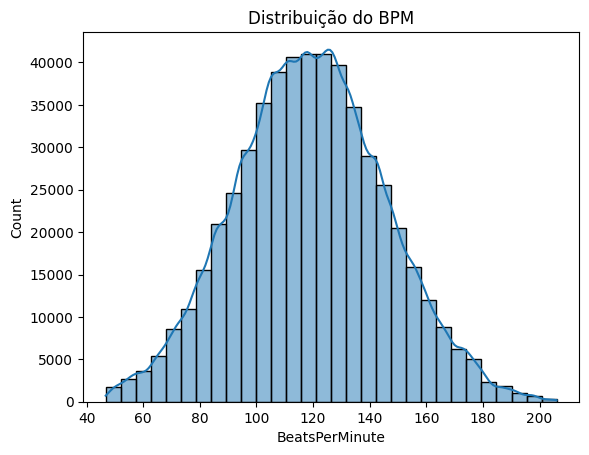

In [18]:
# Histograma do target
sns.histplot(train["BeatsPerMinute"], bins=30, kde=True)
plt.title("Distribuição do BPM")
plt.show()

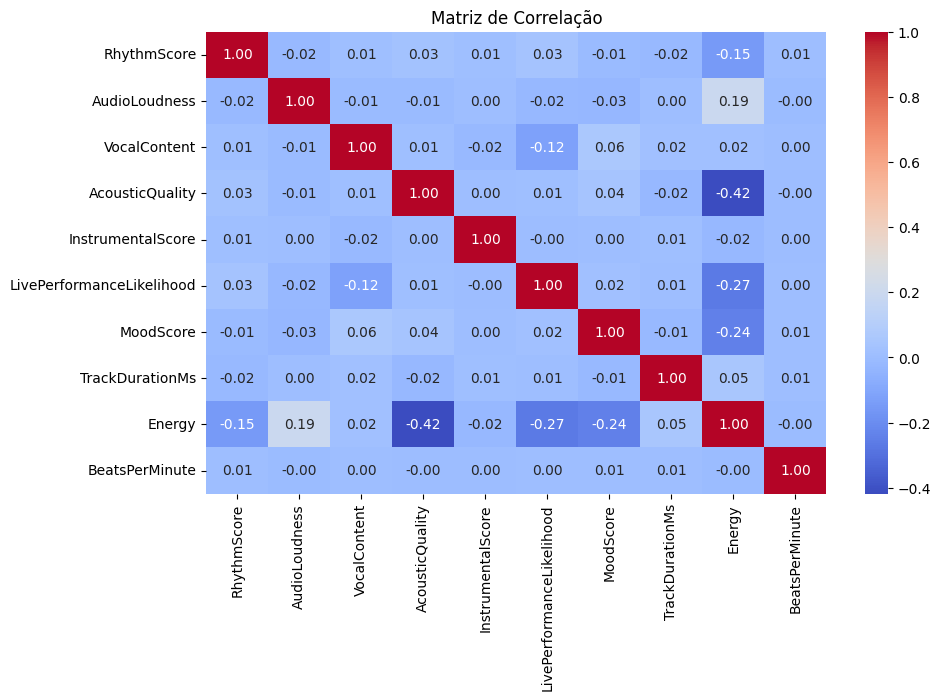

In [19]:
# Correlação
plt.figure(figsize=(10,6))
sns.heatmap(train.drop(columns=["id"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

# Model - Basic Configs

In [3]:
X = train.drop(columns=["id", "BeatsPerMinute"])
y = train["BeatsPerMinute"]

In [21]:
# Escalonamento (importante para regressão linear)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [42]:
def models(X, y, cv_splits=5):
    
    # Base configs
    n_estimators = 500
    learning_rate = 0.05
    max_depth = 6
    subsample = 0.8
    colsample_bytree = 0.8
    random_state = 42
    n_jobs = -1

    # RMSE
    rmse_scorer = make_scorer(mean_squared_error)

    # Models
    models_dict = {
        "Linear": LinearRegression(),
        "Dummy": DummyRegressor(strategy="mean"),
        "XGBoost": XGBRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
            subsample=subsample, colsample_bytree=colsample_bytree, random_state=random_state, n_jobs=n_jobs
        ),
        "RandomForest": RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs
        ),
        "LightGBM": LGBMRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state, force_row_wise=True, verbose=-1
        ),
        "CatBoost": CatBoostRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state, verbose=0
        ),
        "SVR": SVR(C=10, kernel="rbf"),
        "MLP": MLPRegressor(
            hidden_layer_sizes=(64, 32), activation="relu", solver="adam", max_iter=n_estimators, random_state=random_state
        )
    }

    # K-Fold CV
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    metrics_results = []
    predictions = pd.DataFrame({"y": y.values})
    feature_importances_df = pd.DataFrame(index=X.columns)

    for name, model in models_dict.items():
        # Cross-validation for RMSE
        scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=cv)
        metrics_results.append({
            "model": name,
            "rmse_mean": np.mean(scores),
            "rmse_std": np.std(scores)
        })

        # Fit for each model
        model.fit(X, y)
        predictions[name] = model.predict(X)

        # Coef
        if name == "Linear":
            feature_importances_df[name] = model.coef_
            
        elif name in ["XGBoost", "RandomForest", "LightGBM", "CatBoost"]:
            feature_importances_df[name] = model.feature_importances_

            if name == "LightGBM":
                fi = model.feature_importances_
                fi_norm = fi / fi.sum()
                feature_importances_df["LightGBM_norm"] = fi_norm
                
        elif name in ["SVR", "MLP"]:
            # Permutation importance
            result = permutation_importance(model, X, y, n_repeats= 5, random_state=random_state, 
                                            n_jobs=n_jobs, scoring=rmse_scorer)
            feature_importances_df[name] = result.importances_mean
    
    metrics_df = pd.DataFrame(metrics_results)

    return predictions, metrics_df, feature_importances_df

In [16]:
X = X[:10000]
y = y[:10000]

### Fit 01 - All Data
Definition: Fitting all data and without any treament applied.

In [43]:
predictions, metrics_df, feature_importances_df = models(X, y, 5)

In [38]:
fit01_predictions = predictions.copy()
fit01_predictions.head()

,y,Linear,Dummy,XGBoost,RandomForest,LightGBM,CatBoost,SVR,MLP
0,147.53020,118.381054,119.018355,130.730759,118.358352,123.424004,120.495749,118.307224,142.769650
1,136.15963,118.763793,119.018355,126.675430,118.969345,118.781212,118.993121,118.616747,77.684795
2,55.31989,117.752193,119.018355,86.632423,115.950060,100.005502,102.892829,118.604827,82.704655
3,147.91212,118.961604,119.018355,125.895958,119.456417,121.615457,121.087291,118.531734,111.937217
4,89.58511,119.101692,119.018355,112.186081,118.074796,115.182088,117.281892,118.560598,103.043872


In [39]:
fit01_metrics = metrics_df.copy()
fit01_metrics

,model,rmse_mean,rmse_std
0,Linear,714.256985,14.121741
1,Dummy,713.240607,14.094099
2,XGBoost,757.517510,18.439113
3,RandomForest,714.354285,14.421793
4,LightGBM,755.660678,15.283526
5,CatBoost,729.188921,13.519298
6,SVR,714.101931,14.510524
7,MLP,1563.095238,43.674555


In [37]:
fit01_feature_importances = feature_importances_df.copy()
fit01_feature_importances

,Linear,XGBoost,RandomForest,LightGBM,LightGBM_norm,CatBoost,SVR,MLP
RhythmScore,6.820731e-01,0.099633,0.119236,1535,0.115457,12.376910,-1.676199e-10,0.064589
AudioLoudness,3.824874e-02,0.101713,0.103560,1474,0.110869,9.896217,-1.058722e-07,-0.514224
VocalContent,5.244355e-01,0.109476,0.100140,1365,0.102670,9.560769,-1.591616e-12,-0.002301
AcousticQuality,3.213964e-01,0.109525,0.097168,1536,0.115532,10.687031,-1.512035e-10,-0.031048
InstrumentalScore,-1.011759e+00,0.110301,0.075982,1152,0.086649,9.679103,-3.042715e-10,0.022038
LivePerformanceLikelihood,3.577409e+00,0.113896,0.125397,1381,0.103874,10.844632,-1.031935e-09,0.007839
MoodScore,-1.896150e-01,0.114916,0.107312,1471,0.110643,12.676601,-3.885816e-11,-0.039564
TrackDurationMs,-5.352040e-07,0.120907,0.139161,1677,0.126138,12.678550,-2.058503e-01,-3.982796
Energy,-6.252739e-01,0.119633,0.132044,1704,0.128168,11.600186,9.051746e-10,0.018151


### Fit 02 - All Data and Scaler Treament
Definition: 

In [ ]:
predictions, metrics_df, feature_importances_df = models(X, y, 5)

In [ ]:
fit02_predictions = predictions.copy()
fit02_predictions.head()

,index,Linear,Dummy,XGBoost,RandomForest,LightGBM,CatBoost,SVR,MLP
0,147.53020,118.381054,119.018355,130.730759,118.358352,123.424004,120.495749,118.307224,142.769650
1,136.15963,118.763793,119.018355,126.675430,118.969345,118.781212,118.993121,118.616747,77.684795
2,55.31989,117.752193,119.018355,86.632423,115.950060,100.005502,102.892829,118.604827,82.704655
3,147.91212,118.961604,119.018355,125.895958,119.456417,121.615457,121.087291,118.531734,111.937217
4,89.58511,119.101692,119.018355,112.186081,118.074796,115.182088,117.281892,118.560598,103.043872


In [ ]:
fit02_metrics = metrics_df.copy()
fit02_metrics

,model,rmse_mean,rmse_std
0,Linear,714.256985,14.121741
1,Dummy,713.240607,14.094099
2,XGBoost,757.517510,18.439113
3,RandomForest,714.354285,14.421793
4,LightGBM,755.660678,15.283526
5,CatBoost,729.188921,13.519298
6,SVR,714.101931,14.510524
7,MLP,1563.095238,43.674555


In [ ]:
fit02_feature_importances = feature_importances_df.copy()
fit02_feature_importances

,variable,p_value
0,Intercept,0.000000
1,RhythmScore,0.693532
2,AudioLoudness,0.520054
3,VocalContent,0.922578
4,AcousticQuality,0.807085
5,InstrumentalScore,0.611842
6,LivePerformanceLikelihood,0.132028
7,MoodScore,0.876864
8,TrackDurationMs,0.905515
9,Energy,0.580174



Importância das variáveis (coeficientes da regressão linear):
                     Feature      Coef
6                  MoodScore  0.173019
2               VocalContent  0.165261
7            TrackDurationMs  0.162322
0                RhythmScore  0.141764
5  LivePerformanceLikelihood  0.071703
4          InstrumentalScore  0.062072
1              AudioLoudness -0.044446
8                     Energy -0.061034
3            AcousticQuality -0.066866


C:\Users\Computador\AppData\Local\Temp\ipykernel_10408\2497969881.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="Coef", y="Feature", palette="viridis")


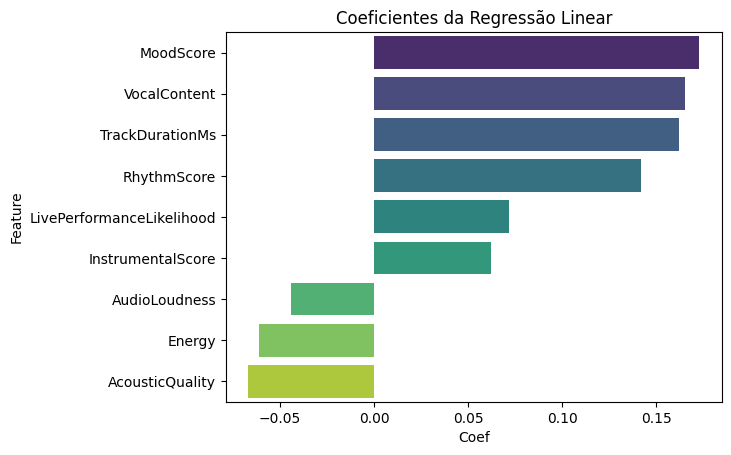

In [25]:
# ================================
# 8. Análise de coeficientes
# ================================
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coef": lr.coef_
}).sort_values(by="Coef", ascending=False)

print("\nImportância das variáveis (coeficientes da regressão linear):")
print(coef_df)

sns.barplot(data=coef_df, x="Coef", y="Feature", palette="viridis")
plt.title("Coeficientes da Regressão Linear")
plt.show()

Cross-validated RMSE: 26.50 (+/- 0.04)

Importância das variáveis (XGBoost):
                     Feature  Importance
7            TrackDurationMs    0.114736
6                  MoodScore    0.113965
8                     Energy    0.111485
3            AcousticQuality    0.110800
4          InstrumentalScore    0.110513
2               VocalContent    0.110248
5  LivePerformanceLikelihood    0.110099
1              AudioLoudness    0.109654
0                RhythmScore    0.108500


C:\Users\Computador\AppData\Local\Temp\ipykernel_10408\3951885964.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x="Importance", y="Feature", palette="viridis")


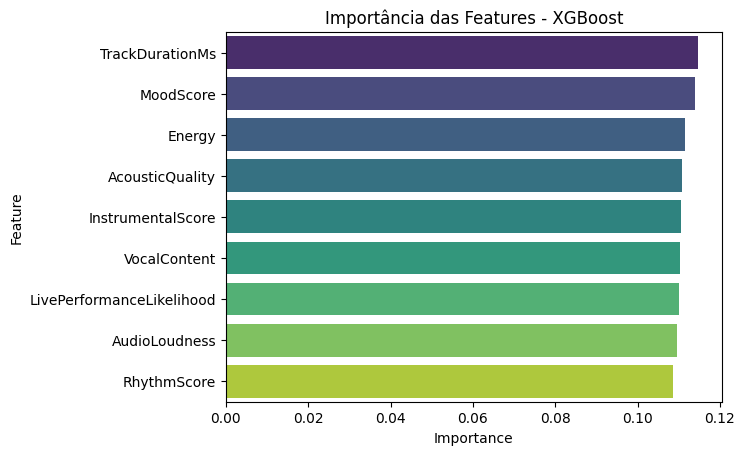

In [27]:
# ================================
# 6. Validação cruzada (K-Fold)
# ================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    xgb, X, y, scoring="neg_root_mean_squared_error", cv=cv
)
print(f"Cross-validated RMSE: {-scores.mean():.2f} (+/- {scores.std():.2f})")

# ================================
# 7. Importância das variáveis
# ================================
importances = xgb.feature_importances_
feat_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})\
            .sort_values(by="Importance", ascending=False)

print("\nImportância das variáveis (XGBoost):")
print(feat_df)

sns.barplot(data=feat_df, x="Importance", y="Feature", palette="viridis")
plt.title("Importância das Features - XGBoost")
plt.show()